In [29]:
import torch
from matplotlib import pyplot as plt
from in_progress.regularizers import LieDerivativeRegularizer, CurvatureRegularizer
from torch import Tensor
from ra_xfads_training.inference_lightning import data_gen
from hydra import compose, initialize

from functools import partial
import pytorch_lightning as pl

In [30]:
from hydra.core.global_hydra import GlobalHydra
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize(version_base=None, config_path='/', job_name="lds")
cfg = compose(config_name="config")

n_trials, n_neurons, n_time_bins = 2000, 100, 75


def v(x: Tensor) -> Tensor:
    return x @ torch.tensor([[0.0, -1.0], [1.0, 0.0]])

_regularizer_list = []
_regularizer_list.append(partial(CurvatureRegularizer, order=1))
_regularizer_list.append(partial(LieDerivativeRegularizer,g=v,normalize=False))
_regularizer_list.append(partial(LieDerivativeRegularizer,g=v,normalize="yang"))
_regularizer_list.append(partial(LieDerivativeRegularizer,g=v,normalize="new"))

In [34]:
r_at_perturbation_magnitudes = []
perturbation_magnitudes = [0.0, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]

for pm in perturbation_magnitudes:
    pl.seed_everything(cfg.seed, workers=True)
    kw = data_gen(cfg, n_neurons, n_time_bins, n_trials,
                  perturbation_magnitude=pm, ode_seed=cfg.seed)[-1]
    z = pts = kw['z_train']
    mean_fn = kw['mean_fn_gt']
    regularizer_vals = []
    for regfcn in _regularizer_list:
        regularizer = regfcn(lambda x_: mean_fn(x_) - x_)
        vals = regularizer.regularizer(pts)
        regularizer_vals.append(vals)
    r_at_perturbation_magnitudes.append(torch.stack(regularizer_vals, dim=-1))
r_at_perturbation_magnitudes = torch.stack(r_at_perturbation_magnitudes, dim=0).cpu().detach().numpy()

Seed set to 1234
/opt/homebrew/Caskroom/miniforge/base/envs/xfads/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
Seed set to 1234
Seed set to 1234
Seed set to 1234
Seed set to 1234
Seed set to 1234
Seed set to 1234


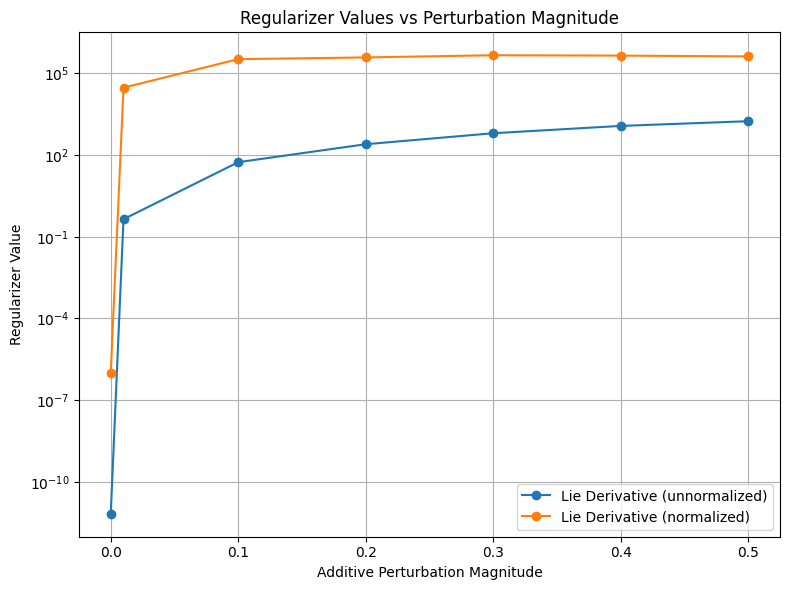

In [57]:
regularizer_labels = [
    "Curvature (order=1)",
    "Lie Derivative (unnormalized)",
    "Lie Derivative (normalized)",
    "Lie Derivative (New norm)"
]

# Plot
plt.figure(figsize=(8, 6))
for i in [1,2]:
    plt.plot(perturbation_magnitudes, r_at_perturbation_magnitudes[:, i], marker='o', label=regularizer_labels[i])

plt.xlabel("Additive Perturbation Magnitude")
plt.ylabel("Regularizer Value")
plt.title("Regularizer Values vs Perturbation Magnitude")
plt.legend()
plt.grid(True)
plt.yscale("log")
# plt.xscale("log")
plt.tight_layout()
plt.savefig("regularizer_vs_perturbation.png",dpi=300, bbox_inches="tight")
plt.show()

In [61]:
A = torch.randn(2,2)
A -= A.clone().T
def v(x: Tensor) -> Tensor:
    return x @ -A
pts = torch.randn(100000,2)
tmp = CurvatureRegularizer(v, order=1).eval_regularizer(pts).cpu().detach().numpy()

(array([9.3660e+03, 2.9061e+04, 2.1362e+04, 1.2741e+04, 7.8690e+03,
        4.9470e+03, 3.2210e+03, 2.3620e+03, 1.6880e+03, 1.2610e+03,
        9.7500e+02, 7.3200e+02, 5.6700e+02, 4.8400e+02, 4.0400e+02,
        3.2200e+02, 2.8700e+02, 2.8200e+02, 1.8600e+02, 1.8300e+02,
        1.5600e+02, 1.4100e+02, 1.1300e+02, 9.3000e+01, 9.3000e+01,
        9.0000e+01, 7.5000e+01, 6.9000e+01, 5.7000e+01, 5.1000e+01,
        4.1000e+01, 5.0000e+01, 3.7000e+01, 4.0000e+01, 3.1000e+01,
        3.8000e+01, 2.3000e+01, 2.5000e+01, 1.9000e+01, 1.5000e+01,
        1.8000e+01, 1.5000e+01, 2.0000e+01, 2.2000e+01, 1.2000e+01,
        1.3000e+01, 1.6000e+01, 9.0000e+00, 1.8000e+01, 9.0000e+00,
        7.0000e+00, 8.0000e+00, 6.0000e+00, 1.1000e+01, 1.0000e+01,
        1.3000e+01, 1.2000e+01, 5.0000e+00, 8.0000e+00, 6.0000e+00,
        6.0000e+00, 8.0000e+00, 6.0000e+00, 7.0000e+00, 9.0000e+00,
        6.0000e+00, 4.0000e+00, 3.0000e+00, 8.0000e+00, 2.0000e+00,
        3.0000e+00, 2.0000e+00, 4.0000e+00, 5.00

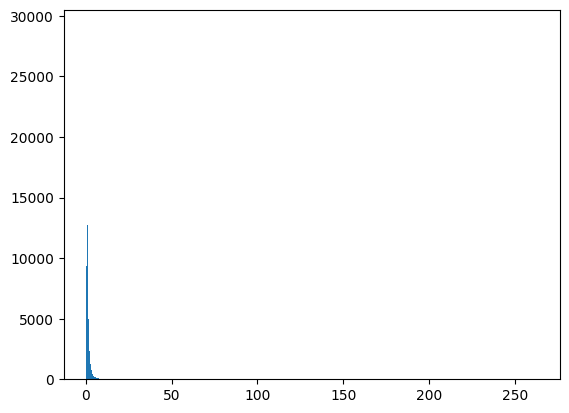

In [62]:
plt.hist(tmp,1000)